In [1]:
import pandas as pd

df = pd.read_csv("timeline_with_coeffs.csv")
print(df.columns)

Index(['year', 'month', 'era', 'key_event', 'category', 'mental_state',
       'intensity', 'source', 'track_theme', '_themes_list',
       'matched_tracks_n', 'matched_track_titles', 'track_emo_score_list',
       'track_emo_score_mean', 'track_emo_score_median',
       'track_emo_score_v2_list', 'track_emo_score_v2_mean',
       'track_emo_score_v2_median', 'matched_themes'],
      dtype='object')


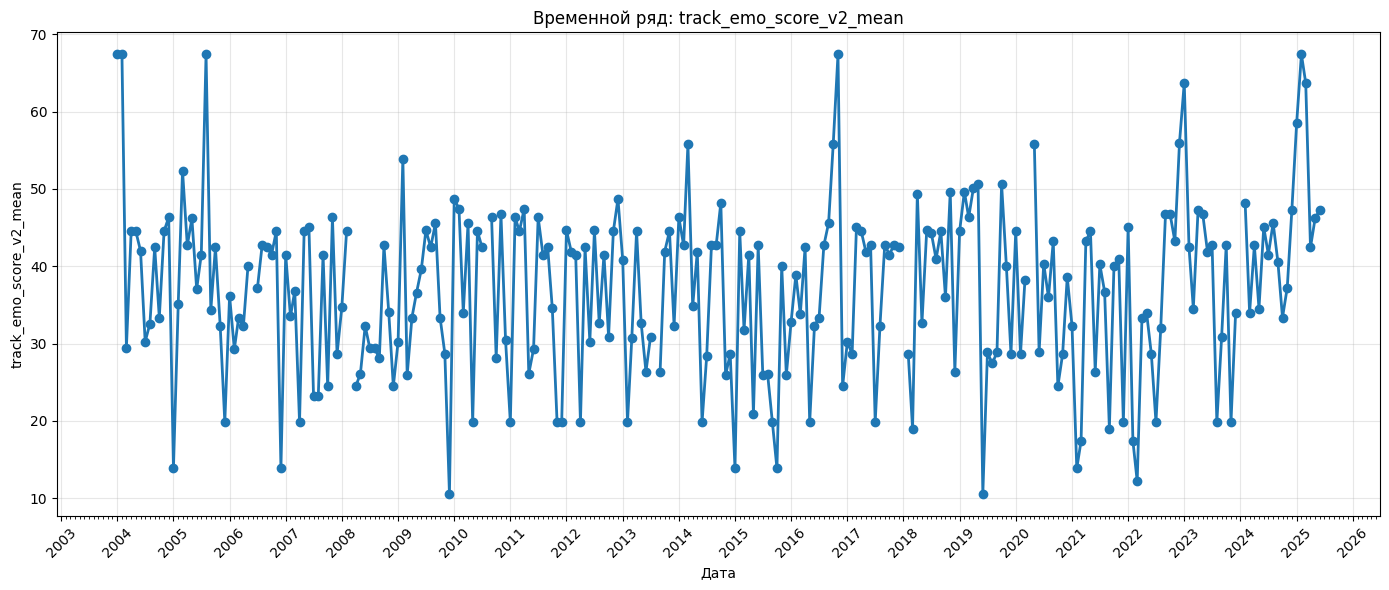

In [2]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


df = pd.read_csv("timeline_with_coeffs.csv")
df["date"] = pd.to_datetime(
    dict(year=df["year"], month=df["month"], day=1)
)
# агрегируем по месяцам
ts = (
    df.groupby("date", as_index=False)["track_emo_score_v2_mean"]
      .mean()
      .sort_values("date")
)
plt.figure(figsize=(14, 6)) # строим временной ряд
plt.plot(
    ts["date"],
    ts["track_emo_score_v2_mean"],
    marker="o",
    linewidth=2
)
plt.title("Временной ряд: track_emo_score_v2_mean")
plt.xlabel("Дата")
plt.ylabel("track_emo_score_v2_mean")
plt.grid(True, alpha=0.3)

# оформление оси времени
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.xaxis.set_minor_locator(mdates.MonthLocator())

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [4]:
import numpy as np
ts = df.copy().sort_values("date")
ts["emo"] = ts["track_emo_score_v2_mean"].astype(float)

mu = ts["emo"].mean()
sd = ts["emo"].std(ddof=1)

thr = 1.5
upper = mu + thr * sd
lower = mu - thr * sd
ts["state_raw"] = np.select(
    [ts["emo"] >= upper, ts["emo"] <= lower],
    [ 1, -1],
    default=0
)
label_map = {1: "mania", 0: "norm", -1: "depression"}
ts["state"] = ts["state_raw"]
ts["state_label"] = ts["state"].map(label_map)

print("mu:", mu, "sd:", sd, "upper:", upper, "lower:", lower)
ts[["date","emo","state_label"]].head()

mu: 37.00427125313281 sd: 11.272347097738832 upper: 53.912791899741066 lower: 20.095750606524565


,date,emo,state_label
0,2004-01-01,67.430130,mania
1,2004-02-01,67.430130,mania
2,2004-03-01,29.452221,norm
3,2004-04-01,44.540729,norm
4,2004-05-01,44.540729,norm


In [5]:
def enforce_min_run(states: pd.Series, min_run: int = 2) -> pd.Series:
    s = states.to_numpy()
    out = s.copy()
    # границы блоков одинаковых значений
    change = np.r_[True, s[1:] != s[:-1], True]
    idx = np.where(change)[0]
    # блоки: [idx[i], idx[i+1])
    for i in range(len(idx)-1):
        a, b = idx[i], idx[i+1]
        val = s[a]
        run_len = b - a
        if val != 0 and run_len < min_run:
            out[a:b] = 0  # слишком короткий эпизод -> норма
    return pd.Series(out, index=states.index)

ts["state"] = enforce_min_run(ts["state_raw"], min_run=2)
ts["state_label"] = ts["state"].map(label_map)

In [6]:
# группировка по смене состояния
ts["block_id"] = (ts["state"] != ts["state"].shift()).cumsum()

episodes = (
    ts.groupby(["block_id", "state"], as_index=False)
      .agg(
          start=("date","min"),
          end=("date","max"),
          months=("date","size"),
          emo_mean=("emo","mean"),
          emo_max=("emo","max"),
          emo_min=("emo","min"),
      )
)

episodes = episodes[episodes["state"] != 0].copy()
episodes["state_label"] = episodes["state"].map(label_map)
episodes = episodes.sort_values("start")

episodes

,block_id,state,start,end,months,emo_mean,emo_max,emo_min,state_label
0,1,1,2004-01-01,2004-02-01,2,67.430130,67.430130,67.430130,mania
2,3,-1,2011-11-01,2011-12-01,2,19.812013,19.812013,19.812013,depression
4,5,-1,2015-09-01,2015-10-01,2,16.824469,19.812013,13.836925,depression
6,7,1,2016-10-01,2016-11-01,2,61.620121,67.430130,55.810112,mania
8,9,-1,2017-07-01,2017-07-01,2,19.812013,19.812013,19.812013,depression
10,11,-1,2021-02-01,2021-03-01,2,15.611500,17.386075,13.836925,depression
12,13,-1,2022-02-01,2022-03-01,2,14.776180,17.386075,12.166284,depression
14,15,1,2022-12-01,2023-01-01,2,65.580922,67.430130,63.731714,mania
16,17,1,2025-01-01,2025-03-01,3,63.228405,67.430130,58.523372,mania


In [7]:
ts["year"] = ts["date"].dt.year
by_year = (
    ts.pivot_table(index="year", columns="state_label", values="date", aggfunc="count", fill_value=0)
      .reset_index()
)
for col in ["mania","depression","norm"]:
    if col not in by_year.columns:
        by_year[col] = 0
by_year["total"] = by_year[["mania","depression","norm"]].sum(axis=1)
by_year["episode_months"] = by_year["mania"] + by_year["depression"]
by_year["episode_share"] = by_year["episode_months"] / by_year["total"]

by_year.sort_values("year")

state_label,year,depression,mania,norm,total,episode_months,episode_share
0,2004,0,2,10,12,2,0.166667
1,2005,0,0,12,12,0,0.000000
2,2006,0,0,12,12,0,0.000000
3,2007,0,0,12,12,0,0.000000
4,2008,0,0,12,12,0,0.000000
5,2009,0,0,12,12,0,0.000000
6,2010,0,0,12,12,0,0.000000
7,2011,2,0,10,12,2,0.166667
8,2012,0,0,12,12,0,0.000000
9,2013,0,0,13,13,0,0.000000


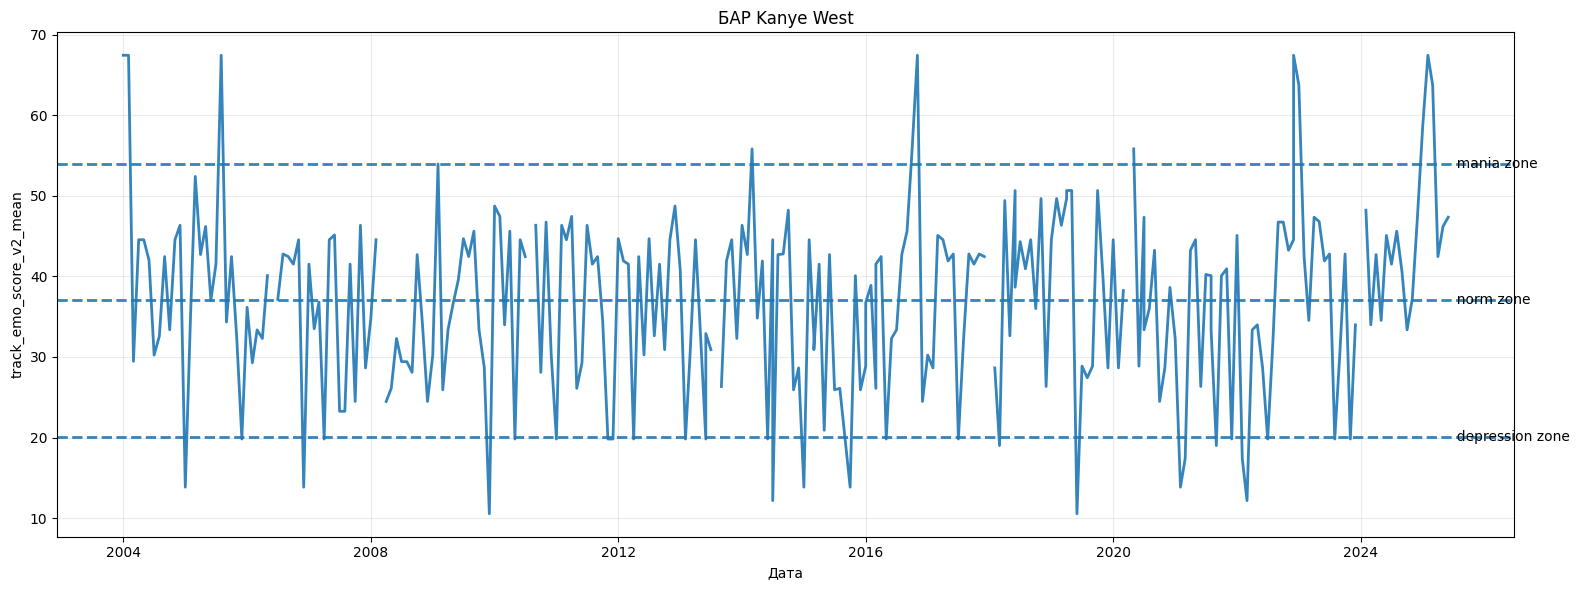

In [8]:
ts = ts.sort_values("date").copy()
mu = ts["emo"].mean()
sd = ts["emo"].std(ddof=1)
thr = 1.5
upper = mu + thr * sd
lower = mu - thr * sd
plt.figure(figsize=(16,6))
ax = plt.gca()
ax.plot(ts["date"], ts["emo"], linewidth=2, alpha=0.9)
ax.axhline(mu,    linestyle="--", linewidth=2, alpha=0.9, label=f"mean = {mu:.2f}")
ax.axhline(upper, linestyle="--", linewidth=2, alpha=0.9, label=f"upper = mean + {thr}σ = {upper:.2f}")
ax.axhline(lower, linestyle="--", linewidth=2, alpha=0.9, label=f"lower = mean - {thr}σ = {lower:.2f}")
ax.text(ts["date"].max(), upper, "  mania zone", va="center")
ax.text(ts["date"].max(), mu,    "  norm zone",  va="center")
ax.text(ts["date"].max(), lower, "  depression zone", va="center")
ax.set_title("БАР Kanye West")
ax.set_xlabel("Дата")
ax.set_ylabel("track_emo_score_v2_mean")
ax.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()

In [13]:
import numpy as np
#выберем, какие колонки использовать как год/месяц
YEAR_COL  = "year" if "year" in df.columns else "release_year"
MONTH_COL = "month" if "month" in df.columns else "release_month"
#приводим ключевые метрики к числам
for c in ["track_rating", "track_rating_count", "track_emo_score_v2_mean"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")
#собираем дату из год/месяц
df["date"] = pd.to_datetime(dict(year=df[YEAR_COL], month=df[MONTH_COL], day=1), errors="coerce")
#строим месячный ряд emo
ts = (
    df.groupby("date", as_index=False)["track_emo_score_v2_mean"]
      .mean()
      .sort_values("date")
      .rename(columns={"track_emo_score_v2_mean": "emo"})
)
mu  = ts["emo"].mean()
sd  = ts["emo"].std(ddof=1)
thr = 1.5
upper = mu + thr * sd
lower = mu - thr * sd
ts["state_raw"] = np.select(
    [ts["emo"] >= upper, ts["emo"] <= lower],
    [1, -1],
    default=0
)
label_map = {1: "mania", 0: "norm", -1: "depression"}
ts["state_label"] = ts["state_raw"].map(label_map)
print("mu:", round(mu, 3), "sd:", round(sd, 3), "upper:", round(upper, 3), "lower:", round(lower, 3))
ts.head()

mu: 37.029 sd: 11.101 upper: 53.681 lower: 20.378


,date,emo,state_raw,state_label
0,2004-01-01,67.430130,1,mania
1,2004-02-01,67.430130,1,mania
2,2004-03-01,29.452221,0,norm
3,2004-04-01,44.540729,0,norm
4,2004-05-01,44.540729,0,norm


In [16]:
df = pd.read_csv("tr_emotions.csv")
# приводим ключевые поля к числам
for c in ["track_rating", "track_rating_count", "track_emo_score_v2"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")  # всё кривое станет nan
# дата релиза
df["release_date"] = pd.to_datetime(df["release_date_clean"], format="%d.%m.%Y", errors="coerce")  # парсим дату


In [19]:
thr = 1.5  # порог
mu = df["track_emo_score_v2"].mean()
sd = df["track_emo_score_v2"].std(ddof=1)   # стандартное отклонение

upper = mu + thr * sd  # верхняя граница для mania
lower = mu - thr * sd   # нижняя граница для depression

df["state"] = np.select(
    [df["track_emo_score_v2"] >= upper, df["track_emo_score_v2"] <= lower],
    ["mania", "depression"],
    default="norm"
)
print("mu:", round(mu, 3), "sd:", round(sd, 3), "upper:", round(upper, 3), "lower:", round(lower, 3))
df["state"].value_counts()

mu: 35.179 sd: 19.232 upper: 64.026 lower: 6.332


state
norm          188
depression     22
mania          12
Name: count, dtype: int64

статтест №1: Welch t-test (норма выше)

H0: